# Кластеризация товаров продавца 

**Цель:** сгруппировать товары по смыслу (по названию/описанию), получить наглядный 2D-график и краткий отчёт по кластерам.

**Подход:**
1) текст → эмбеддинги (SentenceTransformer)  
2) лёгкое *LLM-обогащение* коротких карточек  
3) UMAP (15D) → HDBSCAN  
4) t-SNE(UMAP) для красивой визуализации  
5) авто-лейблы кластеров (топ-термины + доминирующий бренд/категория)


## 1) Импорты и базовые настройки

In [1]:
import os
import re
import json
import math
import time
import hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

import umap
import hdbscan

from sentence_transformers import SentenceTransformer

# Воспроизводимость
SEED = 42
np.random.seed(SEED)


D:\Conda\envs\nlp-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Conda\envs\nlp-gpu\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## 2) Конфиг

In [23]:
CFG = {
    # Данные
    "DATA_PATH": "datasets/parsing.csv",   # <-- поменяй на свой файл (csv/parquet/xlsx)
    "OUTPUT_DIR": "outputs_portfolio",

    # Эмбеддинги
    "MODEL_NAME": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "BATCH_SIZE": 32,

    # LLM-обогащение коротких карточек 
    "USE_LLM_ENRICH": True,
    "LLM_MODEL": "Qwen/Qwen2.5-0.5B-Instruct",
    "LLM_MAX_NEW_TOKENS": 64,

    # Чёрный список «брендов/категорий-паразитов» 
    "BAD_BRANDS": {"gosneui", "nan", "none", "null"},
    "BAD_CATEGORIES": {"gosneui", "nan", "none", "null"},

    # «слишком короткие»
    "SHORT_TITLE_LEN": 8,
    "SHORT_DESC_LEN": 20,

    # Числовые признаки 
    "USE_NUMERIC": False,
    "W_TEXT": 1.0,
    "W_NUM": 0.25,

    # Акцент на категорию
    "USE_CATEGORY_FEATURE": True,
    "W_CAT": 1,   # 0.3..1.5 — чем выше, тем сильнее категория влияет

    # UMAP (пространство для кластеризации)
    "UMAP_N_COMPONENTS": 15,
    "UMAP_N_NEIGHBORS": 30,
    "UMAP_MIN_DIST": 0.05,
    "UMAP_METRIC": "cosine",

    # HDBSCAN (кластеризация)
    "HDB_MIN_CLUSTER_SIZE": 5,
    "HDB_MIN_SAMPLES": 2,
    "HDB_SELECTION_METHOD": "eom",

    # t-SNE (только визуализация)
    "TSNE_PERPLEXITY": 10,
    "TSNE_MAX_ITER": 1000,
}

OUT_DIR = Path(CFG["OUTPUT_DIR"])
(OUT_DIR / "cache").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "figures").mkdir(parents=True, exist_ok=True)

print("OUT_DIR:", OUT_DIR.resolve())


OUT_DIR: D:\DS\outputs_portfolio


## 3) Загрузка данных

Ожидаем таблицу с колонками вроде:
- `title` / `name` / `product_name`
- `description` / `desc`
- (опционально) `brand`, `category`, `price`, `rating` и т.п.

Колонки подхватываются по «кандидатам».


In [24]:
def pick_col(df: pd.DataFrame, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def read_table(path: str) -> pd.DataFrame:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Файл не найден: {p.resolve()}")
    suf = p.suffix.lower()
    if suf in [".csv"]:
        return pd.read_csv(p)
    if suf in [".parquet"]:
        return pd.read_parquet(p)
    if suf in [".xlsx", ".xls"]:
        return pd.read_excel(p)
    raise ValueError(f"Неизвестный формат: {suf}. Используй csv/parquet/xlsx.")

df_raw = read_table(CFG["DATA_PATH"])

title_col = pick_col(df_raw, ["title","name","product_name","product","item_name"])
desc_col  = pick_col(df_raw, ["description","desc","details","text","product_description"])
brand_col = pick_col(df_raw, ["brand","vendor","manufacturer"])
cat_col   = pick_col(df_raw, ["category","cat","group","section"])
price_col = pick_col(df_raw, ["price","cost","amount","value"])
rating_col= pick_col(df_raw, ["rating","stars","score"])

print("Columns picked:")
print(" title:", title_col)
print(" desc :", desc_col)
print(" brand:", brand_col)
print(" cat  :", cat_col)
print(" price:", price_col)
print(" rating:", rating_col)

df = df_raw.copy()

df["title"] = df[title_col].astype(str) if title_col else ""
df["description"] = df[desc_col].astype(str) if desc_col else ""
df["brand"] = df[brand_col].astype(str) if brand_col else ""
df["category"] = df[cat_col].astype(str) if cat_col else ""

if price_col:
    df["price"] = pd.to_numeric(df[price_col], errors="coerce")
else:
    df["price"] = np.nan

if rating_col:
    df["rating"] = pd.to_numeric(df[rating_col], errors="coerce")
else:
    df["rating"] = np.nan

df.head()


Columns picked:
 title: name
 desc : description
 brand: brand
 cat  : category
 price: price
 rating: rating


,id,name,brand,price,rating,feedbacks,image,description,seller,category,subcategory,sellerrating,sellerfeedback,sellerordes,url,title
0,2315339908,"Крем от варикоза, для сосудов, отеков и тяжест...",nan,185,4.7,294,https://ir-5.ozone.ru/s3/multimedia-1-r/795847...,Описание:Вес нетто: 20 гФункция:1. Улучшает ва...,gosneui,gosneui,Аптека > Парафармацевтика > Лечебные средства ...,NaN,65326,NaN,https://www.ozon.ru/product/krem-ot-varikoza-d...,"Крем от варикоза, для сосудов, отеков и тяжест..."
1,2623222451,"Статуэтка йоги Бегемот, настольный декор для д...",nan,126,3.3,172,https://ir-5.ozone.ru/s3/multimedia-1-0/770024...,Материал: смолаРазмер: как на фотоЦвет: как на...,gosneui,gosneui,Дом и сад > Декор и интерьер > Оформление инте...,NaN,65326,NaN,https://www.ozon.ru/product/statuetka-yogi-beg...,"Статуэтка йоги Бегемот, настольный декор для д..."
2,2648920196,40 мл крема для ног с мочевиной 60% для очень ...,nan,176,5.0,9,https://ir-5.ozone.ru/s3/multimedia-1-u/771080...,Описание Срок годности: 3 года Содержимое нетт...,gosneui,gosneui,Красота и здоровье > Уход за телом > Кремы > К...,NaN,65326,NaN,https://www.ozon.ru/product/40-ml-krema-dlya-n...,40 мл крема для ног с мочевиной 60% для очень ...
3,2523076061,Подарочный набор карандашей для студентов 6-в-...,nan,104,4.6,213,https://ir-5.ozone.ru/s3/multimedia-1-6/772198...,Описание продукта:1. Название продукта: Набор ...,gosneui,gosneui,Канцелярские товары > Письменные принадлежност...,NaN,65326,NaN,https://www.ozon.ru/product/podarochnyy-nabor-...,Подарочный набор карандашей для студентов 6-в-...
4,2623226565,Подарочный набор карандашей для студентов 6-в-...,nan,97,4.7,3,https://ir-5.ozone.ru/s3/multimedia-1-o/775444...,Описание продукта:1. Название продукта: Набор ...,gosneui,gosneui,Канцелярские товары > Письменные принадлежност...,NaN,65326,NaN,https://www.ozon.ru/product/podarochnyy-nabor-...,Подарочный набор карандашей для студентов 6-в-...


In [25]:
def clean_token(s):
    s = str(s).strip()
    if s.lower() in {"gosneui", "nan", "none", ""}:
        return ""
    return s

df["category"] = df["category"].apply(clean_token)
df["brand"]    = df["brand"].apply(clean_token)
# если у тебя есть seller и он тоже gosneui:
if "seller" in df.columns:
    df["seller"] = df["seller"].apply(clean_token)


## 4) Подготовка текста

- Для эмбеддингов используем только смысловой текст: `title + description`
- `brand/category` не конкатенируем в текст, чтобы не “склеивать” товары по шумным метаданным (например, когда категория/бренд заполнены мусором).
- При этом категорию используем отдельно как weak-supervision признак: добавляем one-hot категорию в общий вектор с весом W_CAT, чтобы грубо разделять ассортимент по типам товаров.
- Дедупликация делается по text_key, чтобы одинаковые карточки не искажали плотности для HDBSCAN.


In [27]:
def clean_text(s: str) -> str:
    s = "" if s is None else str(s)

    # HTML/пробелы
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    # «маркетплейсный мусор» — лучше выкинуть, чтобы не попадало в топ-термины/эмбеддинги
    junk_patterns = [
        r"показать\s+полностью",
        r"описание\s+показать\s+полностью",
        r"пожалуйста",
        r"описание",
    ]
    for p in junk_patterns:
        s = re.sub(p, " ", s, flags=re.IGNORECASE)

    s = re.sub(r"\s+", " ", s).strip()
    return s

def norm_nan_like(s: str) -> str:
    # приводит 'nan'/'None'/'NULL' к пустой строке
    s = "" if s is None else str(s).strip()
    if s.lower() in {"nan","none","null"}:
        return ""
    return s

df["title"] = df["title"].fillna("").map(clean_text)
df["description"] = df["description"].fillna("").map(clean_text)
df["brand"] = df["brand"].fillna("").map(clean_text).map(norm_nan_like)
df["category"] = df["category"].fillna("").map(clean_text).map(norm_nan_like)

df["text_base"] = (df["title"] + ". " + df["description"]).str.strip()
df["text_base"] = df["text_base"].str.replace(r"\s+", " ", regex=True).str.strip()

# Ключ для дедупа (низкий регистр)
df["text_key"] = df["text_base"].str.lower().str.strip()

# Флаг «слишком коротко»
mask_short = df["title"].str.len().lt(CFG["SHORT_TITLE_LEN"]) & df["description"].str.len().lt(CFG["SHORT_DESC_LEN"])
df["is_too_short"] = mask_short

# Для category-фичи лучше иметь нормализованную категорию
df["category_clean"] = (
    df["category"].fillna("").astype(str).str.strip()
    .str.replace(r"\s+", " ", regex=True)
)
df["category_clean"] = df["category_clean"].apply(lambda x: "" if x.lower() in CFG["BAD_CATEGORIES"] else x)
df["category_clean"] = df["category_clean"].where(df["category_clean"] != "", "unknown")

print("rows:", len(df))
print("too_short:", int(df["is_too_short"].sum()))
print("unique categories:", df["category_clean"].nunique())


rows: 84
too_short: 1
unique categories: 12


## 5) Рабочий датасет для кластеризации (уникальные карточки)

Кластеризуем по `df_work` (уникальные `text_key`).  
Потом размаппим кластера обратно на исходные строки (`df_all`).


In [29]:
df_all = df.copy()

df_work = df_all.drop_duplicates("text_key").reset_index(drop=True).copy()
print("unique rows:", len(df_work))

# Текст, который реально пойдёт в эмбеддинги 
df_work["text_for_model"] = df_work["text_base"].copy()


unique rows: 75


## 6) LLM-обогащение коротких карточек

Короткие названия вроде «Шапка», «Сумка» плохо кластеризуются.  
LLM может сгенерировать **тип товара + ключевые атрибуты**, чтобы эмбеддинги стали информативнее.


In [30]:
def make_fingerprint(keys, extra: str) -> str:
    # Берём подпись из модели + длины + сэмпла ключей
    sample = "|".join(keys[:50])
    raw = f"{extra}||n={len(keys)}||{sample}"
    return hashlib.sha256(raw.encode("utf-8")).hexdigest()[:12]

def try_load_llm():
    try:
        from transformers import pipeline
        gen = pipeline(
            "text-generation",
            model=CFG["LLM_MODEL"],
            device_map="auto",
        )
        return gen
    except Exception as e:
        print("LLM not available -> disable USE_LLM_ENRICH")
        print("Reason:", repr(e))
        return None

BANNED_LLMTOKENS = {
    "подходит","эффективно","пожалуйста","описание","показать","полностью","лучший","качественный","идеально"
}

def parse_generated(text: str) -> str:
    # хотим получить короткую «сводку» для эмбеддингов без «воды»
    text = text.strip()
    text = re.sub(r"\s+", " ", text)

    # убрать типичный мусор
    for w in BANNED_LLMTOKENS:
        text = re.sub(rf"\b{re.escape(w)}\b", " ", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()

    return text[:300]

if CFG["USE_LLM_ENRICH"]:
    gen = try_load_llm()
else:
    gen = None

if gen is None:
    CFG["USE_LLM_ENRICH"] = False

# Кэшируем обогащение по text_key
keys = df_work["text_key"].tolist()
fp_llm = make_fingerprint(keys, extra=f"{CFG['LLM_MODEL']}|{CFG['USE_LLM_ENRICH']}")
llm_cache_path = OUT_DIR / "cache" / f"llm_enrich_{fp_llm}.jsonl"

enrich_map = {}

if CFG["USE_LLM_ENRICH"] and llm_cache_path.exists():
    with open(llm_cache_path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            enrich_map[obj["text_key"]] = obj["enriched"]
    print("Loaded LLM enrich cache:", len(enrich_map))

if CFG["USE_LLM_ENRICH"]:
    def enrich_row(row):
        # если и так длинно — не трогаем
        if not row["is_too_short"]:
            return row["text_for_model"]

        k = row["text_key"]
        if k in enrich_map:
            return enrich_map[k]

        # Строго структурно, без маркетинговых фраз
        prompt = (
            "Нормализуй карточку товара для кластеризации. "
            "Дай только СУЩЕСТВИТЕЛЬНЫЕ/короткие атрибуты, без фраз типа 'подходит/эффективно'. "
            "Формат ОДНОЙ строкой:\n"
            "TYPE=<тип товара>; ATTR=<3-6 ключевых слов>; USE=<назначение/контекст 2-4 слова>\n\n"
            f"TITLE: {row['title']}\n"
            f"DESC: {row['description']}\n"
            f"BRAND: {row['brand']}\n"
            f"CATEGORY: {row['category_clean']}\n"
        )

        out = gen(
            prompt,
            max_new_tokens=CFG["LLM_MAX_NEW_TOKENS"],
            do_sample=False,
            temperature=0.0,
        )[0]["generated_text"]

        # берём хвост после промпта
        enriched = out[len(prompt):].strip()
        enriched = parse_generated(enriched)

        merged = (row["text_for_model"] + " | " + enriched).strip()
        enrich_map[k] = merged
        return merged

    # Применяем (на маленьких наборах можно без батчей)
    df_work["text_for_model"] = df_work.apply(enrich_row, axis=1)

    # Сохраняем кэш
    with open(llm_cache_path, "w", encoding="utf-8") as f:
        for k, v in enrich_map.items():
            f.write(json.dumps({"text_key": k, "enriched": v}, ensure_ascii=False) + "\n")
    print("Saved LLM enrich cache:", llm_cache_path)
else:
    print("LLM enrich disabled.")


Device set to use cuda:0


Loaded LLM enrich cache: 1
Saved LLM enrich cache: outputs_portfolio\cache\llm_enrich_fbac384a7815.jsonl


## 7) Эмбеддинги текста (с простым кэшем)

Кэш завязан на:
- имя модели эмбеддингов
- fingerprint текста (`text_key`)


In [31]:
texts = df_work["text_for_model"].fillna("").astype(str).tolist()

fp_emb = make_fingerprint(df_work["text_key"].tolist(), extra=CFG["MODEL_NAME"])
emb_cache_path = OUT_DIR / "cache" / f"emb_{fp_emb}.npy"
print("emb cache:", emb_cache_path)

emb = None
if emb_cache_path.exists():
    try:
        emb = np.load(emb_cache_path)
        if emb.shape[0] != len(texts):
            print("emb cache mismatch -> recompute")
            emb = None
    except Exception:
        emb = None

if emb is None:
    model = SentenceTransformer(CFG["MODEL_NAME"])
    emb = model.encode(
        texts,
        batch_size=CFG["BATCH_SIZE"],
        show_progress_bar=True,
        normalize_embeddings=True,
    )
    emb = np.asarray(emb, dtype=np.float32)
    np.save(emb_cache_path, emb)
    print("computed & saved:", emb.shape)
else:
    print("loaded emb:", emb.shape)


emb cache: outputs_portfolio\cache\emb_039cd472f46f.npy
loaded emb: (75, 384)


## 8) Фичи: текст (+ опционально числа + категория)

По умолчанию `USE_NUMERIC=False`, чтобы на маленьком каталоге числовые поля не ухудшали смысловые группы.

**Акцент на категорию:** включён `USE_CATEGORY_FEATURE=True`.  
Это добавляет one-hot признак категории с весом `W_CAT`, чтобы товары из разных категорий (например, «Электроника» и «Обувь») реже попадали в один кластер.  
Если категории в данных шумные/кривые — можно выключить или снизить `W_CAT` (например до 0.3).


In [32]:
X_text = emb * float(CFG["W_TEXT"])

X_num = None
if CFG["USE_NUMERIC"]:
    num_cols = []
    if "price" in df_work.columns:
        num_cols.append("price")
    if "rating" in df_work.columns:
        num_cols.append("rating")

    if num_cols:
        X_num_raw = df_work[num_cols].copy()
        # простая обработка
        if "price" in X_num_raw.columns:
            X_num_raw["price"] = np.log1p(X_num_raw["price"])
        X_num_raw = X_num_raw.fillna(X_num_raw.median(numeric_only=True))
        X_num = StandardScaler().fit_transform(X_num_raw.values).astype(np.float32)

# Категория как фича (one-hot) 
X_cat = None
if CFG.get("USE_CATEGORY_FEATURE", False) and "category_clean" in df_work.columns:
    cats = df_work["category_clean"].fillna("unknown").astype(str).str.strip()
    # выкидываем паразитные категории
    cats = cats.apply(lambda x: "unknown" if x.lower() in CFG["BAD_CATEGORIES"] else x)
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    X_cat = ohe.fit_transform(cats.to_frame()).astype(np.float32)

# Собираем полный вектор
parts = [X_text.astype(np.float32)]

if X_num is not None:
    if X_num.shape[0] != X_text.shape[0]:
        raise ValueError(f"X_num rows {X_num.shape[0]} != X_text rows {X_text.shape[0]} (проверь df_work)")
    parts.append(X_num.astype(np.float32) * float(CFG["W_NUM"]))

if X_cat is not None:
    if X_cat.shape[0] != X_text.shape[0]:
        raise ValueError(f"X_cat rows {X_cat.shape[0]} != X_text rows {X_text.shape[0]} (проверь df_work)")
    parts.append(X_cat.astype(np.float32) * float(CFG["W_CAT"]))

X_full = np.hstack(parts).astype(np.float32)
print("X_full:", X_full.shape, "| text dim:", X_text.shape[1], "| cat dim:", (X_cat.shape[1] if X_cat is not None else 0))


X_full: (75, 396) | text dim: 384 | cat dim: 12


In [34]:
import warnings
warnings.filterwarnings("ignore", message="n_jobs value .* overridden")

import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score
import umap
import hdbscan

X_base = X_full          
df_base = df_work        
cat_col = "category_clean" if "category_clean" in df_base.columns else "category"

categories = df_base[cat_col].fillna("").astype(str).values

#SEED = 42  

# ФУНКЦИЯ ОЦЕНКИ 
def eval_run(X, labels, probs, categories):
    labels = np.asarray(labels)
    n = len(labels)

    non_noise = labels != -1
    noise_share = float((labels == -1).mean())
    n_clusters = len(set(labels)) - (1 if -1 in set(labels) else 0)

    # sizes
    if n_clusters > 0:
        sizes = pd.Series(labels[non_noise]).value_counts()
        size_min = int(sizes.min())
        n_small = int((sizes < 5).sum())
    else:
        size_min = 0
        n_small = 999

    # purity (weighted)
    purity = np.nan
    if n_clusters > 0:
        tmp = pd.DataFrame({"lab": labels, "cat": categories})
        tmp = tmp[tmp["lab"] != -1]
        purities, weights = [], []
        for lab, g in tmp.groupby("lab"):
            top = g["cat"].value_counts().iloc[0]
            purities.append(top / len(g))
            weights.append(len(g))
        purity = float(np.average(purities, weights=weights))

    # silhouette on non-noise only (need >=2 clusters)
    sil = np.nan
    if n_clusters >= 2 and non_noise.sum() >= 10:
        sil = float(silhouette_score(X[non_noise], labels[non_noise]))

    mean_prob = np.nan
    share_prob05 = np.nan
    if probs is not None and len(probs) == n and non_noise.any():
        mean_prob = float(np.mean(probs[non_noise]))
        share_prob05 = float(np.mean(probs[non_noise] > 0.5))

    penalty = 0.0
    if n_clusters < 5 or n_clusters > 12:
        penalty += 0.25
    if noise_share > 0.25:
        penalty += 0.25
    if n_small > 0:
        penalty += 0.25

    score = 0.0
    if not np.isnan(purity):
        score += 0.65 * purity
    if not np.isnan(mean_prob):
        score += 0.25 * mean_prob
    if not np.isnan(sil):
        score += 0.10 * max(0.0, sil)  # чтобы не ломалось отрицательным

    score -= penalty

    return {
        "score": score,
        "n_clusters": n_clusters,
        "noise_share": noise_share,
        "size_min": size_min,
        "n_small(<5)": n_small,
        "purity_w": purity,
        "mean_prob": mean_prob,
        "share_prob>0.5": share_prob05,
        "silhouette": sil,
    }

# GRID ПАРАМЕТРОВ
grid = []
for umap_n_neighbors in [15, 30]:
    for umap_min_dist in [0.05, 0.1]:
        for hdb_min_cluster_size in [4, 5, 6]:
            for hdb_min_samples in [1, 2]:
                for hdb_method in ["eom", "leaf"]:
                    grid.append((umap_n_neighbors, umap_min_dist, hdb_min_cluster_size, hdb_min_samples, hdb_method))

results = []

# ПРОГОН
for (nn, md, mcs, ms, method) in grid:
    reducer = umap.UMAP(
        n_neighbors=nn,
        min_dist=md,
        n_components=15,
        metric="cosine",
        random_state=SEED,
    )
    Z = reducer.fit_transform(X_base)

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        cluster_selection_method=method,
    )
    labels = clusterer.fit_predict(Z)
    probs = getattr(clusterer, "probabilities_", None)

    row = {
        "umap_n_neighbors": nn,
        "umap_min_dist": md,
        "hdb_min_cluster_size": mcs,
        "hdb_min_samples": ms,
        "hdb_method": method,
    }
    row.update(eval_run(Z, labels, probs, categories))
    results.append(row)

res_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)

display(res_df.head(10))

best = res_df.iloc[0].to_dict()

keys = ["umap_n_neighbors","umap_min_dist","hdb_min_cluster_size","hdb_min_samples","hdb_method",
        "score","n_clusters","noise_share","purity_w","mean_prob","silhouette"]

print("\nBEST PARAMS:")
print({k: best[k] for k in keys})



,umap_n_neighbors,umap_min_dist,hdb_min_cluster_size,hdb_min_samples,hdb_method,score,n_clusters,noise_share,size_min,n_small(<5),purity_w,mean_prob,share_prob>0.5,silhouette
0,15,0.05,5,1,eom,0.916921,7,0.053333,5,0,0.915493,0.968041,1.0,0.798405
1,30,0.05,6,2,leaf,0.916274,6,0.133333,6,0,0.923077,0.964046,1.0,0.752621
2,30,0.05,6,2,eom,0.916274,6,0.133333,6,0,0.923077,0.964046,1.0,0.752621
3,15,0.10,5,1,eom,0.916134,7,0.053333,5,0,0.915493,0.967708,1.0,0.791365
4,30,0.05,5,2,leaf,0.915011,7,0.066667,5,0,0.928571,0.947985,1.0,0.744435
5,30,0.05,5,2,eom,0.915011,7,0.066667,5,0,0.928571,0.947985,1.0,0.744435
6,30,0.10,5,2,leaf,0.913932,7,0.066667,5,0,0.928571,0.955289,1.0,0.715382
7,30,0.10,5,2,eom,0.913932,7,0.066667,5,0,0.928571,0.955289,1.0,0.715382
8,15,0.05,5,1,leaf,0.912638,9,0.093333,5,0,0.941176,0.968831,1.0,0.586652
9,15,0.10,5,1,leaf,0.911043,9,0.093333,5,0,0.941176,0.967021,1.0,0.575228



BEST PARAMS:
{'umap_n_neighbors': 15, 'umap_min_dist': 0.05, 'hdb_min_cluster_size': 5, 'hdb_min_samples': 1, 'hdb_method': 'eom', 'score': 0.9169210973785694, 'n_clusters': 7, 'noise_share': 0.05333333333333334, 'purity_w': 0.9154929577464789, 'mean_prob': 0.9680408696157423, 'silhouette': 0.7984045743942261}


## 9) UMAP (15D) + HDBSCAN

Ниже — главный шаг проекта: строим кластера товаров.

1. Берём X_full — признаки товара (вектор из текста, + при необходимости добавляем категорию/числа отдельными фичами).

2. Сжимаем их через UMAP до 15 измерений — это “рабочее” пространство, где сохраняется смысловая близость, но алгоритмам проще.

3. Запускаем HDBSCAN — он находит плотные группы и умеет помечать “непонятные” товары как noise = -1.

Последующий t-SNE/2D график — только картинка для человека, сами кластера считаются в 15D.


In [35]:
umap_model = umap.UMAP(
    n_neighbors=int(best["umap_n_neighbors"]),
    n_components=int(CFG["UMAP_N_COMPONENTS"]),   
    min_dist=float(best["umap_min_dist"]),
    metric=str(CFG["UMAP_METRIC"]),               
    random_state=SEED,
)
emb_umap = umap_model.fit_transform(X_full)



clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(best["hdb_min_cluster_size"]),
    min_samples=int(best["hdb_min_samples"]),
    cluster_selection_method=str(best["hdb_method"]),  # "eom" или "leaf"
)



labels = clusterer.fit_predict(emb_umap)
proba = getattr(clusterer, "probabilities_", None)

df_work["cluster"] = labels
if proba is not None:
    df_work["cluster_prob"] = proba

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_share = float((labels == -1).mean())

print(f"clusters={n_clusters} noise={noise_share:.2%}")
print("Using BEST params:",
      f"UMAP(n_neighbors={int(best['umap_n_neighbors'])}, min_dist={float(best['umap_min_dist'])}) | "
      f"HDBSCAN(min_cluster_size={int(best['hdb_min_cluster_size'])}, min_samples={int(best['hdb_min_samples'])}, method={str(best['hdb_method'])})")


clusters=7 noise=5.33%
Using BEST params: UMAP(n_neighbors=15, min_dist=0.05) | HDBSCAN(min_cluster_size=5, min_samples=1, method=eom)


## 10) Вывод метрик

In [36]:
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def cluster_metrics(X, labels, categories=None, probs=None):
    labels = np.asarray(labels)
    n = len(labels)

    noise_mask = labels == -1
    non_noise_mask = ~noise_mask

    n_noise = int(noise_mask.sum())
    noise_share = n_noise / n

    uniq = sorted([c for c in set(labels) if c != -1])
    n_clusters = len(uniq)
    sizes = pd.Series(labels[non_noise_mask]).value_counts().sort_index() if n_clusters > 0 else pd.Series(dtype=int)

    size_min = int(sizes.min()) if n_clusters > 0 else 0
    size_median = float(sizes.median()) if n_clusters > 0 else 0.0
    size_max = int(sizes.max()) if n_clusters > 0 else 0
    n_small = int((sizes < 5).sum()) if n_clusters > 0 else 0  # "мелкие" кластера

    out = {
        "N": n,
        "n_clusters": n_clusters,
        "noise_share": noise_share,
        "noise_n": n_noise,
        "size_min": size_min,
        "size_median": size_median,
        "size_max": size_max,
        "n_clusters_size<5": n_small,
    }

    if n_clusters >= 2 and non_noise_mask.sum() >= 10:
        X_nn = X[non_noise_mask]
        y_nn = labels[non_noise_mask]
        out["silhouette"] = float(silhouette_score(X_nn, y_nn, metric="euclidean"))
        out["davies_bouldin"] = float(davies_bouldin_score(X_nn, y_nn))
        out["calinski_harabasz"] = float(calinski_harabasz_score(X_nn, y_nn))
    else:
        out["silhouette"] = np.nan
        out["davies_bouldin"] = np.nan
        out["calinski_harabasz"] = np.nan

    if probs is not None:
        probs = np.asarray(probs)
        if len(probs) == n:
            out["mean_prob_non_noise"] = float(probs[non_noise_mask].mean()) if non_noise_mask.any() else np.nan
            out["share_prob>0.5"] = float((probs[non_noise_mask] > 0.5).mean()) if non_noise_mask.any() else np.nan

    if categories is not None:
        cat = pd.Series(categories).astype(str).fillna("")
        df_tmp = pd.DataFrame({"label": labels, "cat": cat})
        df_tmp = df_tmp[df_tmp["label"] != -1]
        if len(df_tmp) > 0:
            # per cluster: max(cat_count)/cluster_size
            purities = []
            weights = []
            for lab, g in df_tmp.groupby("label"):
                counts = g["cat"].value_counts()
                purity = counts.iloc[0] / len(g)
                purities.append(purity)
                weights.append(len(g))
            out["cat_purity_weighted"] = float(np.average(purities, weights=weights))
        else:
            out["cat_purity_weighted"] = np.nan

    return out

metrics = cluster_metrics(
    X=emb_umap, 
    labels=labels,
    categories=df_work.get("category_clean", df_work.get("category")),
    probs=proba if "proba" in globals() else None
)

pd.Series(metrics).sort_index()


N                        75.000000
calinski_harabasz      1590.989506
cat_purity_weighted       0.915493
davies_bouldin            0.299411
mean_prob_non_noise       0.968041
n_clusters                7.000000
n_clusters_size<5         0.000000
noise_n                   4.000000
noise_share               0.053333
share_prob>0.5            1.000000
silhouette                0.798405
size_max                 17.000000
size_median               9.000000
size_min                  5.000000
dtype: float64

Получившиеся метрики можно оценить следующим образом:

- N = 75 — столько объектов участвовало в кластеризации (после фильтрации/чистки данных).

- n_clusters = 7 — получилось 7 устойчивых кластеров: это “не слишком много”, чтобы читать глазами, и достаточно, чтобы выделить основные сегменты.

- noise_share = 0.053 (noise_n = 4) — около 5% объектов помечены как шум (-1). Это хороший баланс: модель не “впихивает” всё в кластера любой ценой и честно выделяет выбросы.

- size_min = 5, size_median = 9, size_max = 17 — кластера не микроскопические, без “мусорных” групп по 1–2 товара.

- n_clusters_size<5 = 0 — вообще нет кластеров меньше 5 объектов → результат выглядит устойчивым и не случайным.

- mean_prob_non_noise = 0.968 и share_prob>0.5 = 1.0 — HDBSCAN очень уверенно присваивает точки кластерам (все не-шумовые товары имеют вероятность > 0.5).

- silhouette = 0.798 — высокий показатель: внутри кластера товары действительно близки, между кластерами — хорошо разделены.

- davies_bouldin = 0.299 — низкое значение (лучше, когда меньше): кластера компактные и далеко друг от друга.

- calinski_harabasz = 1590.99 — высокий индекс (лучше, когда больше). Эту метрику удобно использовать для сравнения разных прогонов (между собой).

Вывод: разбиение получилось стабильным, хорошо разделённым и интерпретируемым, с малым шумом и без мелких “мусорных” кластеров.

## 11) Маппинг результатов обратно на исходный датасет

Кластеризацию делали на df_work (уникальные карточки по text_key), чтобы дубли не искажали плотности.

Теперь переносим cluster (и cluster_prob) обратно в df_all, чтобы каждая строка исходного датасета получила метку кластера и можно было делать аналитику/выгрузки.

In [38]:
map_cluster = dict(zip(df_work["text_key"], df_work["cluster"]))
df_all["cluster"] = df_all["text_key"].map(map_cluster).fillna(-1).astype(int)

if "cluster_prob" in df_work.columns:
    map_prob = dict(zip(df_work["text_key"], df_work["cluster_prob"]))
    df_all["cluster_prob"] = df_all["text_key"].map(map_prob)

print("df_all clusters value_counts:")
print(df_all["cluster"].value_counts().head(10))


df_all clusters value_counts:
cluster
 1    24
 4    17
 2    11
 0     9
 5     9
 3     5
 6     5
-1     4
Name: count, dtype: int64


## 12) Визуализация t-SNE(UMAP15D)

- точки шума (`-1`) рисуем серым
- центры кластеров подписываем номером


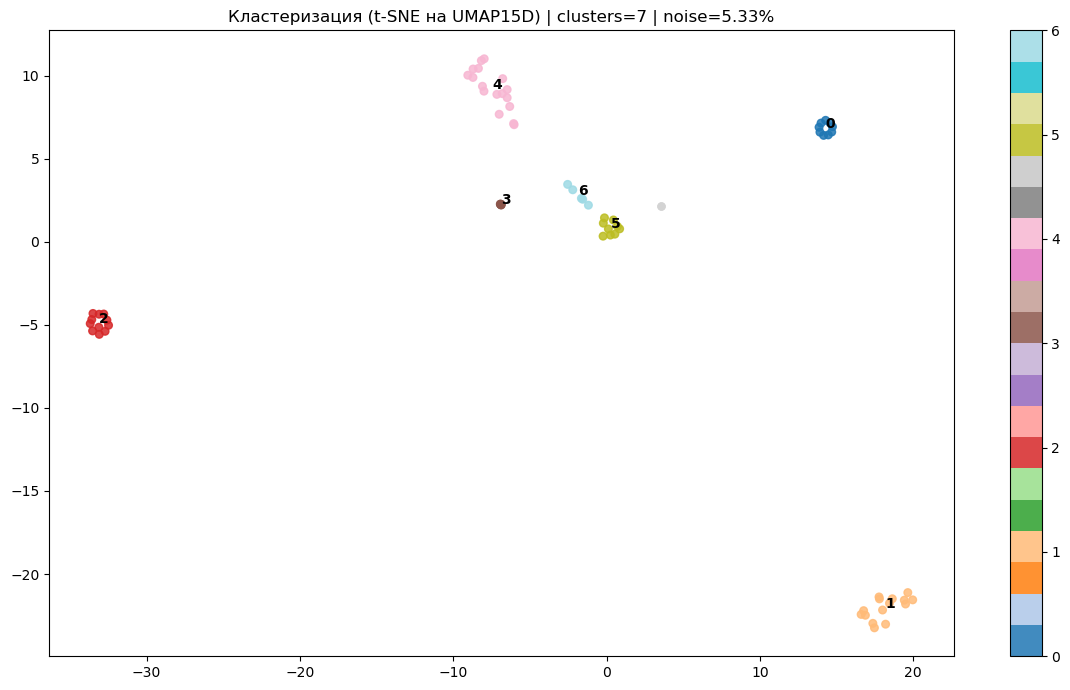

In [18]:
import inspect

tsne_kwargs = dict(
    n_components=2,
    perplexity=float(CFG["TSNE_PERPLEXITY"]),
    random_state=SEED,
)
sig = inspect.signature(TSNE).parameters
if "max_iter" in sig:
    tsne_kwargs["max_iter"] = int(CFG["TSNE_MAX_ITER"])
else:
    tsne_kwargs["n_iter"] = int(CFG["TSNE_MAX_ITER"])

tsne = TSNE(**tsne_kwargs)
Z = tsne.fit_transform(emb_umap)

plt.figure(figsize=(12, 7))

mask_noise = (labels == -1)
if mask_noise.any():
    plt.scatter(Z[mask_noise, 0], Z[mask_noise, 1], s=25, c="lightgray", alpha=0.7, label="noise (-1)")

mask_cl = ~mask_noise
sc = plt.scatter(Z[mask_cl, 0], Z[mask_cl, 1], s=30, c=labels[mask_cl], cmap="tab20", alpha=0.85)

plt.title(f"Кластеризация (t-SNE на UMAP15D) | clusters={n_clusters} | noise={noise_share:.2%}")
plt.colorbar(sc)

for c in sorted(set(labels)):
    if c == -1:
        continue
    idx = np.where(labels == c)[0]
    if len(idx) == 0:
        continue
    cx, cy = Z[idx, 0].mean(), Z[idx, 1].mean()
    plt.text(cx, cy, str(c), fontsize=10, weight="bold")

plt.tight_layout()
plt.show()


На графике показана 2D-проекция (t-SNE) пространства UMAP(15D), в котором выполнялась кластеризация HDBSCAN. Видно 7 компактных и хорошо разделённых групп: кластера выглядят как отдельные “островки”, пересечений почти нет. Доля шума небольшая (≈5%), то есть алгоритм не пытается насильно “впихнуть” выбросы в кластера.

## 12) Авто-лейблы кластеров (топ-термины + доминирующий бренд/категория)

Дальше кластера подписываются автоматически: берутся самые частые термины из названий/описаний товаров кластера + (если есть) доминирующая категория/бренд. Подписи нужны только для быстрого понимания смысла кластера.


In [39]:
# RU/EN стоп-слова 
RU_STOP = {
    "и","в","во","на","по","для","от","до","из","за","к","ко","с","со","у","о","об","при","без","над","под",
    "это","как","так","то","же","ли","не","ни","мы","вы","они","он","она","оно","я","ты",
    "шт","мм","см","мл","г","кг","л","шт.","№",
    # «маркетплейсные термины»
    "показать","полностью","описание","пожалуйста","эффективно","подходит","материала","изготовлена",
    "комплект","набор","цвет","размер","упаковка","товар",
}
EN_STOP = {"the","and","or","for","with","to","of","a","in","on","is","it","this","that","pcs","pc","set"}
STOPWORDS = RU_STOP | EN_STOP

def safe_tokenize(s: str):
    s = "" if s is None else str(s)
    s = s.lower()
    s = re.sub(r"[^a-zа-я0-9\s]+", " ", s, flags=re.IGNORECASE)
    toks = [t for t in s.split() if len(t) >= 3 and t not in STOPWORDS]
    return " ".join(toks)

df_work["tfidf_text"] = df_work["text_for_model"].map(safe_tokenize)

# TF-IDF по всем документам (для топ-терминов)
vec = TfidfVectorizer(max_features=4000, ngram_range=(1,2), min_df=1)
X_tfidf = vec.fit_transform(df_work["tfidf_text"].values)
feat = np.array(vec.get_feature_names_out())

def _norm_val(x: str) -> str:
    x = "" if x is None else str(x).strip()
    if x.lower() in {"nan","none","null"}:
        return ""
    return x

def dominant_value(series: pd.Series, bad=set(), thr=0.7):
    s = series.map(_norm_val)
    s = s[s != ""]
    if len(s) == 0:
        return ""
    top = s.value_counts().iloc[:1]
    val = top.index[0]
    share = float(top.iloc[0] / len(s))
    if val.lower() in {b.lower() for b in bad}:
        return ""
    return val if share >= thr else ""

def top_terms_for_cluster(mask, k=6):
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return []
    scores = np.asarray(X_tfidf[idx].mean(axis=0)).ravel()
    top_idx = scores.argsort()[::-1]
    terms = []
    for i in top_idx:
        if scores[i] <= 0:
            break
        t = feat[i]
        # отсечём «слишком общие» токены
        if any(w in t.split() for w in STOPWORDS):
            continue
        terms.append(t)
        if len(terms) >= k:
            break
    return terms

# Отчёт
n_total = len(df_all)
n_noise = int((df_all["cluster"] == -1).sum())

print("\nОТЧЁТ ПО КЛАСТЕРАМ")
print("="*60)
print(f"Всего объектов: {n_total}")
print(f"Всего кластеров (без шума): {n_clusters}")
print(f"Шум (label = -1): {n_noise} объектов\n")

for c in sorted(set(df_work["cluster"])):
    if c == -1:
        continue
    part = df_work[df_work["cluster"] == c].copy()
    size = len(part)

    dom_cat = dominant_value(part["category_clean"], bad=CFG["BAD_CATEGORIES"])
    dom_brand = dominant_value(part["brand"], bad=CFG["BAD_BRANDS"])

    terms = top_terms_for_cluster(df_work["cluster"].values == c, k=6)

    label_parts = [x for x in [dom_cat, dom_brand] if x]
    label = " | ".join(label_parts) if label_parts else ""
    if terms:
        label = (label + (" | " if label else "") + ", ".join(terms))[:140]
    else:
        label = label or "misc"

    print(f"=== Cluster {c} | size={size} | label: {label}")
    for _, r in part.head(10).iterrows():
        print(f"- {r['title']} | {r.get('brand','')} | {r.get('category','')}")
    if size > 10:
        print(f"... +{size-10} more")
    print()

# Шум
print("=== NOISE (-1) examples")
noise_part = df_all[df_all["cluster"] == -1].drop_duplicates("text_key").copy()
for _, r in noise_part.head(12).iterrows():
    print(f"- {r['title']} | {r.get('brand','')} | {r.get('category','')}")



ОТЧЁТ ПО КЛАСТЕРАМ
Всего объектов: 84
Всего кластеров (без шума): 7
Шум (label = -1): 4 объектов

=== Cluster 0 | size=9 | label: Одежда | nan, толстовка, трусы, свитер, печать, рукава
- Толстовка SYJWY | SYJWY | Одежда
- Олимпийка |  | Одежда
- Толстовка |  | Одежда
- Трусы боксеры Omsa Cotton, 3 шт | Omsa | Одежда
- Джемпер |  | Одежда
- Футболка |  | Одежда
- Полукомбинезон рабочий мужской СПРУТ "Стандарт с СОП" спецодежда | СПРУТ | Одежда
- Джемпер |  | Одежда
- Комплект трусов шорты, 3 шт |  | Одежда

=== Cluster 1 | size=15 | label: unknown | может, шапка, кожу, входит, продукта, эта
- Крем от варикоза, для сосудов, отеков и тяжести в ногах, сосудистых звездочек, тромбоза, Эффективен при лечении варикозного расширения вен, 20г |  | 
- Статуэтка йоги Бегемот, настольный декор для дома и офиса |  | 
- 40 мл крема для ног с мочевиной 60% для очень сухой и потрескавшейся кожи ног |  | 
- Подарочный набор карандашей для студентов 6-в-1 Набор канцелярских принадлежностей для учебы |  

Модель выделила 7 интерпретируемых сегментов и пометила 4 товара как шум (≈5%).
Большинство кластеров совпадают с бизнес-логикой: Одежда, Аксессуары, Канцелярские товары, Строительство и ремонт, Дом и сад.
Отдельный кластер unknown в основном состоит из товаров с пустой/некачественной категоризацией — это скорее сигнал о проблемах данных, чем ошибка модели.
Товары обуви (их мало) попали в noise, что логично для плотностной кластеризации: мало точек → нет устойчивой “плотной” группы.

## 13) Экспорт результатов (CSV)



In [20]:
out_csv = OUT_DIR / "results.csv"
df_all.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("saved:", out_csv)


saved: outputs_portfolio\results.csv
